In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import transformers
import os

In [2]:
max_length = 128  # Maximum length of input sentence to the model.
batch_size = 16
epochs = 3

# Labels in our dataset.
labels = ["not_similar", "similar"]

### Part 1. Pre-processing Data

**1.1 Load the dataset:**
The dataset consists of 3 files: Train - Dev - Test.

In [3]:
# Read in tsv file, skip bad lines
train_df = pd.read_csv("MSRP Dataset/train.tsv", sep='\t', on_bad_lines='skip')
test_df = pd.read_csv("MSRP Dataset/test.tsv", sep='\t', on_bad_lines='skip')
dev_df = pd.read_csv("MSRP Dataset/dev.tsv", sep='\t', on_bad_lines='skip')

In [4]:
# Shape of the data
print(f"Total train samples: {train_df.shape[0]}")
print(f"Total test samples: {test_df.shape[0]}")
print(f"Total dev samples: {dev_df.shape[0]}")

Total train samples: 3458
Total test samples: 1639
Total dev samples: 480


In [5]:
# Data overview
train_df.head(5) 

,Quality,#1 ID,#2 ID,#1 String,#2 String
0,1,702876,702977,"Amrozi accused his brother, whom he called ""th...","Referring to him as only ""the witness"", Amrozi..."
1,0,2108705,2108831,Yucaipa owned Dominick's before selling the ch...,Yucaipa bought Dominick's in 1995 for $693 mil...
2,1,1330381,1330521,They had published an advertisement on the Int...,"On June 10, the ship's owners had published an..."
3,0,3344667,3344648,"Around 0335 GMT, Tab shares were up 19 cents, ...","Tab shares jumped 20 cents, or 4.6%, to set a ..."
4,1,1236820,1236712,"The stock rose $2.11, or about 11 percent, to ...",PG&E Corp. shares jumped $1.63 or 8 percent to...


**1.2 Data Cleaning:** Detecting and removing noises or unnecessary information.

In [6]:
# Detecting noise information
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3458 entries, 0 to 3457
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Quality    3458 non-null   int64 
 1   #1 ID      3458 non-null   int64 
 2   #2 ID      3458 non-null   int64 
 3   #1 String  3458 non-null   object
 4   #2 String  3441 non-null   object
dtypes: int64(3), object(2)
memory usage: 135.2+ KB


In [7]:
train_df.dropna(inplace=True)
dev_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3441 entries, 0 to 3457
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Quality    3441 non-null   int64 
 1   #1 ID      3441 non-null   int64 
 2   #2 ID      3441 non-null   int64 
 3   #1 String  3441 non-null   object
 4   #2 String  3441 non-null   object
dtypes: int64(3), object(2)
memory usage: 161.3+ KB


In [9]:
# Train target distribution
print("Train target distribution")
print(train_df.Quality.value_counts())

Train target distribution
Quality
1    2316
0    1125
Name: count, dtype: int64


In [10]:
# Valid target distribution
print("Valid target distribution")
print(dev_df.Quality.value_counts())

Valid target distribution
Quality
1    330
0    146
Name: count, dtype: int64


**1.3 Data Reduction and Transformation:**
Since we only need the sentence pairs and quality, reduce '#1 ID' and '#2 ID'

In [11]:
train_df = train_df.drop(['#1 ID', '#2 ID'], axis=1)
dev_df = dev_df.drop(['#1 ID', '#2 ID'], axis=1)
test_df = test_df.drop(['#1 ID', '#2 ID'], axis=1)

In [12]:
train_df.head()

,Quality,#1 String,#2 String
0,1,"Amrozi accused his brother, whom he called ""th...","Referring to him as only ""the witness"", Amrozi..."
1,0,Yucaipa owned Dominick's before selling the ch...,Yucaipa bought Dominick's in 1995 for $693 mil...
2,1,They had published an advertisement on the Int...,"On June 10, the ship's owners had published an..."
3,0,"Around 0335 GMT, Tab shares were up 19 cents, ...","Tab shares jumped 20 cents, or 4.6%, to set a ..."
4,1,"The stock rose $2.11, or about 11 percent, to ...",PG&E Corp. shares jumped $1.63 or 8 percent to...


### 2. Main model

In [13]:
class BertSemanticDataGenerator(tf.keras.utils.Sequence):
    """Generates batches of data.

    Args:
        sentence_pairs: Array of premise and hypothesis input sentences.
        labels: Array of labels.
        batch_size: Integer batch size.
        shuffle: boolean, whether to shuffle the data.
        include_targets: boolean, whether to incude the labels.

    Returns:
        Tuples `([input_ids, attention_mask, `token_type_ids], labels)`
        (or just `[input_ids, attention_mask, `token_type_ids]`
         if `include_targets=False`)
    """

    def __init__(
        self,
        sentence_pairs,
        labels,
        batch_size=batch_size,
        shuffle=True,
        include_targets=True,
    ):
        self.sentence_pairs = sentence_pairs
        self.labels = labels
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.include_targets = include_targets
        # Load our BERT Tokenizer to encode the text.
        # We will use MiniLM-L12-H384-uncased pretrained model (for lower-case text).
        self.tokenizer = transformers.BertTokenizer.from_pretrained(
            "microsoft/MiniLM-L12-H384-uncased", do_lower_case=True
        )
        self.indexes = np.arange(len(self.sentence_pairs))
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch.
        return len(self.sentence_pairs) // self.batch_size

    def __getitem__(self, idx):
        # Retrieves the batch of index.
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        sentence_pairs = self.sentence_pairs[indexes]

        # With BERT tokenizer's batch_encode_plus batch of both the sentences are
        # encoded together and separated by [SEP] token.
        encoded = self.tokenizer.batch_encode_plus(
            sentence_pairs.tolist(),
            add_special_tokens=True,
            max_length=max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_tensors="tf",
        )

        # Convert batch of encoded features to numpy array.
        input_ids = np.array(encoded["input_ids"], dtype="int32")
        attention_masks = np.array(encoded["attention_mask"], dtype="int32")
        token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

        # Set to true if data generator is used for training/validation.
        if self.include_targets:
            labels = np.array(self.labels[indexes], dtype="int32")
            return [input_ids, attention_masks, token_type_ids], labels
        else:
            return [input_ids, attention_masks, token_type_ids]

    def on_epoch_end(self):
        # Shuffle indexes after each epoch if shuffle is set to True.
        if self.shuffle:
            np.random.RandomState(42).shuffle(self.indexes)

In [14]:
y_train = tf.keras.utils.to_categorical(train_df.Quality, num_classes=2)
y_dev = tf.keras.utils.to_categorical(dev_df.Quality, num_classes=2)
y_test = tf.keras.utils.to_categorical(test_df.Quality, num_classes=2)

In [15]:
# Create the model under a distribution strategy scope.
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Encoded token ids from BERT tokenizer.
    input_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="input_ids"
    )
    # Attention masks indicates to the model which tokens should be attended to.
    attention_masks = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="attention_masks"
    )
    # Token type ids are binary masks identifying different sequences in the model.
    token_type_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="token_type_ids"
    )
    # Loading pretrained BERT model.
    bert_model = transformers.TFBertModel.from_pretrained("microsoft/MiniLM-L12-H384-uncased")
    # Freeze the BERT model to reuse the pretrained features without modifying them.
    bert_model.trainable = False

    bert_output = bert_model.bert(
        input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids
    )
    sequence_output = bert_output.last_hidden_state
    pooled_output = bert_output.pooler_output
    # Add trainable layers on top of frozen layers to adapt the pretrained features on the new data.
    bi_lstm = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True)
    )(sequence_output)
    # Applying hybrid pooling approach to bi_lstm sequence output.
    avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
    max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
    concat = tf.keras.layers.concatenate([avg_pool, max_pool])
    dropout = tf.keras.layers.Dropout(0.3)(concat)
    output = tf.keras.layers.Dense(2, activation="softmax")(dropout)
    model = tf.keras.models.Model(
        inputs=[input_ids, attention_masks, token_type_ids], outputs=output
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["acc"],
    )


print(f"Strategy: {strategy}")
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Strategy: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x000001C05CD155B0>
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
_______________________

In [16]:
# Create the train data generator.
train_data = BertSemanticDataGenerator(
    train_df[["#1 String", "#2 String"]].values.astype("str"),
    y_train,
    batch_size=batch_size,
    shuffle=True,
)

# Create the validation data generator.
valid_data = BertSemanticDataGenerator(
    dev_df[["#1 String", "#2 String"]].values.astype("str"),
    y_dev,
    batch_size=batch_size,
    shuffle=True,
)

# Create the test data generator.
test_data = BertSemanticDataGenerator(
    test_df[["#1 String", "#2 String"]].values.astype("str"),
    y_test,
    batch_size=batch_size,
    shuffle=False,
)

In [17]:
import os
checkpoint_path = "checkpoint_/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [18]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs= epochs,
    use_multiprocessing=True,
    workers=-1,
    callbacks=[cp_callback],
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\vtung\anaconda3\envs\nlpProjects\lib\site-packages\transformers\tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 1/3
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 18/215 [=>............................] - ETA: 45s - loss: 0.6543 - acc: 0.6771

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


139/215 [==================>...........] - ETA: 17s - loss: 0.6012 - acc: 0.6938

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


185/215 [========================>.....] - ETA: 6s - loss: 0.5966 - acc: 0.6959

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


211/215 [============================>.] - ETA: 0s - loss: 0.5916 - acc: 0.6991

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


215/215 [==============================] - ETA: 0s - loss: 0.5900 - acc: 0.7003

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


215/215 [==============================] - 79s 275ms/step - loss: 0.5900 - acc: 0.7003 - val_loss: 0.5181 - val_acc: 0.7478

Epoch 00001: saving model to checkpoint_\cp.ckpt


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 2/3
 80/215 [==========>...................] - ETA: 30s - loss: 0.4987 - acc: 0.7531

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


151/215 [====================>.........] - ETA: 14s - loss: 0.4972 - acc: 0.7546

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


183/215 [========================>.....] - ETA: 7s - loss: 0.4939 - acc: 0.7551

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


191/215 [=========================>....] - ETA: 5s - loss: 0.4958 - acc: 0.7536

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


215/215 [==============================] - ETA: 0s - loss: 0.4870 - acc: 0.7608

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


215/215 [==============================] - 54s 251ms/step - loss: 0.4870 - acc: 0.7608 - val_loss: 0.4528 - val_acc: 0.7823

Epoch 00002: saving model to checkpoint_\cp.ckpt
Epoch 3/3
 60/215 [=======>......................] - ETA: 32s - loss: 0.4205 - acc: 0.8083

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 94/215 [============>.................] - ETA: 25s - loss: 0.4108 - acc: 0.8172

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


106/215 [=============>................] - ETA: 23s - loss: 0.4176 - acc: 0.8125

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


111/215 [==============>...............] - ETA: 22s - loss: 0.4175 - acc: 0.8102

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


215/215 [==============================] - ETA: 0s - loss: 0.4185 - acc: 0.8099

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


215/215 [==============================] - 53s 246ms/step - loss: 0.4185 - acc: 0.8099 - val_loss: 0.3956 - val_acc: 0.8147

Epoch 00003: saving model to checkpoint_\cp.ckpt


In [19]:
# Unfreeze the bert_model.
bert_model.trainable = True
# Recompile the model to make the change effective.
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_masks (InputLayer)    [(None, 128)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 33360000    input_ids[0][0]                  
                                                                 attention_masks[0][0]        

In [21]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs= epochs,
    use_multiprocessing=True,
    workers=-1,
    callbacks=[cp_callback],
)

Epoch 1/3
 71/215 [========>.....................] - ETA: 1:14 - loss: 0.2146 - accuracy: 0.9181

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


106/215 [=============>................] - ETA: 56s - loss: 0.2131 - accuracy: 0.9204

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


107/215 [=============>................] - ETA: 55s - loss: 0.2130 - accuracy: 0.9206

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


135/215 [=================>............] - ETA: 41s - loss: 0.2136 - accuracy: 0.9199

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


183/215 [========================>.....] - ETA: 16s - loss: 0.2080 - accuracy: 0.9225

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


215/215 [==============================] - ETA: 0s - loss: 0.2145 - accuracy: 0.9174

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


215/215 [==============================] - 117s 545ms/step - loss: 0.2145 - accuracy: 0.9174 - val_loss: 0.2454 - val_accuracy: 0.9073

Epoch 00001: saving model to checkpoint_\cp.ckpt
Epoch 2/3
 31/215 [===>..........................] - ETA: 1:35 - loss: 0.1552 - accuracy: 0.9375

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 86/215 [===========>..................] - ETA: 1:06 - loss: 0.1722 - accuracy: 0.9404

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


142/215 [==================>...........] - ETA: 37s - loss: 0.1620 - accuracy: 0.9445

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


150/215 [===================>..........] - ETA: 33s - loss: 0.1624 - accuracy: 0.9429

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


159/215 [=====================>........] - ETA: 28s - loss: 0.1605 - accuracy: 0.9426

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


215/215 [==============================] - ETA: 0s - loss: 0.1575 - accuracy: 0.9453

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


215/215 [==============================] - 117s 544ms/step - loss: 0.1575 - accuracy: 0.9453 - val_loss: 0.2615 - val_accuracy: 0.8901

Epoch 00002: saving model to checkpoint_\cp.ckpt
Epoch 3/3
 91/215 [===========>..................] - ETA: 1:04 - loss: 0.1239 - accuracy: 0.9622

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 98/215 [============>.................] - ETA: 1:00 - loss: 0.1251 - accuracy: 0.9605

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


121/215 [===============>..............] - ETA: 48s - loss: 0.1231 - accuracy: 0.9618

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


133/215 [=================>............] - ETA: 42s - loss: 0.1210 - accuracy: 0.9624

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


215/215 [==============================] - ETA: 0s - loss: 0.1200 - accuracy: 0.9613

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


215/215 [==============================] - 117s 545ms/step - loss: 0.1200 - accuracy: 0.9613 - val_loss: 0.2532 - val_accuracy: 0.9009

Epoch 00003: saving model to checkpoint_\cp.ckpt


In [25]:
tf.keras.models.save_model(model, 'my_model')

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


### 3. Evaluation and Testing

In [22]:
# Accuracy
model.evaluate(test_data)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


 31/101 [========>.....................] - ETA: 13s - loss: 0.3163 - accuracy: 0.8730

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 32/101 [========>.....................] - ETA: 13s - loss: 0.3124 - accuracy: 0.8730

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 36/101 [=========>....................] - ETA: 12s - loss: 0.3123 - accuracy: 0.8750

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 47/101 [============>.................] - ETA: 10s - loss: 0.3171 - accuracy: 0.8697

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 67/101 [==================>...........] - ETA: 6s - loss: 0.3393 - accuracy: 0.8647

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 84/101 [=======================>......] - ETA: 3s - loss: 0.3361 - accuracy: 0.8653

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


101/101 [==============================] - 20s 197ms/step - loss: 0.3459 - accuracy: 0.8632


[0.3459264934062958, 0.8632425665855408]

In [23]:
from sklearn.metrics import f1_score
# F1 score

test_data = BertSemanticDataGenerator(
    test_df[["#1 String", "#2 String"]].values.astype("str"), labels=None, batch_size=1, shuffle=False, include_targets=False,
)

# Make predictions on test data
y_pred = model.predict(test_data)

# Convert predictions from probabilities to labels
y_pred = np.argmax(y_pred, axis=1)

# Convert actual labels from one-hot encoding to integers
y_true = np.argmax(y_test, axis=1)

# Calculate F1-score
f1 = f1_score(y_true, y_pred)

print("F1-score:", f1)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\vtung\anaconda3\envs\nlpProjects\lib\site-packages\transformers\tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Be aware, overflowing tokens are not returned for the setting you have chosen, 

F1-score: 0.900763358778626


In [24]:
from sklearn.metrics import accuracy_score

y_true = np.argmax(y_test, axis=1)
test_data = BertSemanticDataGenerator(
    test_df[["#1 String", "#2 String"]].values.astype("str"), labels=None, batch_size=1, shuffle=False, include_targets=False,
)

y_pred = model.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\vtung\anaconda3\envs\nlpProjects\lib\site-packages\transformers\tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Be aware, overflowing tokens are not returned for the setting you have chosen, 

Accuracy: 0.8644171779141104


In [27]:
def check_similarity(sentence1, sentence2):
    sentence_pairs = np.array([[str(sentence1), str(sentence2)]])
    test_data = BertSemanticDataGenerator(
        sentence_pairs, labels=None, batch_size=1, shuffle=False, include_targets=False,
    )

    proba = model.predict(test_data[0])[0]
    idx = np.argmax(proba)
    proba = f"{proba[idx]: .2f}"
    pred = labels[idx]
    return pred, proba

In [28]:
sentence1 = "There is a church across the river"
sentence2 = "A church is present across the river"

result = check_similarity(sentence1, sentence2)
print(result)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\vtung\anaconda3\envs\nlpProjects\lib\site-packages\transformers\tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


('similar', ' 0.98')


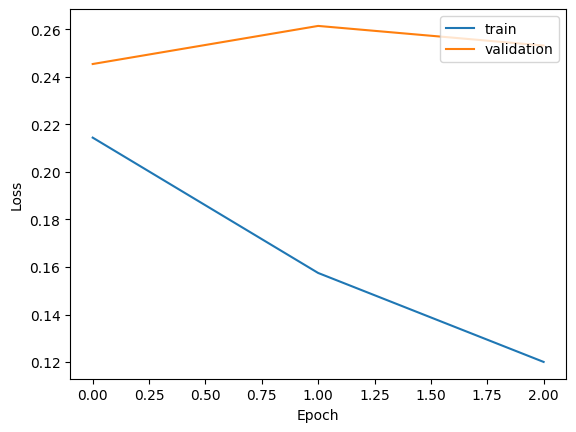

In [29]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','validation'],loc='upper right')
plt.show()